This notebook was made for Predict Future Sales competition on Kaggle.
Some of the feature generation ideas were borrowed from this notebook:
kaggle.com/homiarafarhana/predict-future-sales

## Contents

#### Data extraction
* load data
* check data

#### Data improvement
* improve shop data
* improve item categories data
* improve items data
* prepare grid for feature generation
* join train and test sets

#### Features engeneering
* add data for lags generation
* generate lags
* add trend features
* add month and year

#### Modelling and training
* initialize models
* insert training data into all of the models

#### Submission data
* predict target data with models
* ensemble predictions
* create submission

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


## Data extraction

In [52]:
import time
from contextlib import contextmanager
import gc
import typing as tp
import pickle
import joblib

from matplotlib import pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoost, Pool, CatBoostRegressor

%matplotlib inline

#### Load data

In [2]:
train = pd.read_csv("sales_train.csv")
test = pd.read_csv("test.csv")
print("train: {}, test: {}".format(train.shape, test.shape))

train: (2935849, 6), test: (214200, 3)


In [3]:
shops = pd.read_csv("shops.csv")
categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")

#### Check data
Now we will set a plot for train set data distribution to check if the data is OK.

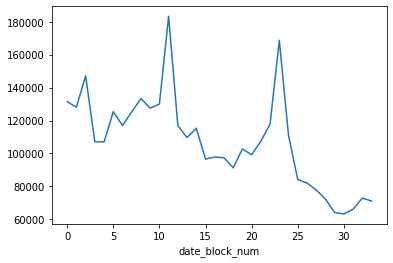

In [4]:
sale_by_month = train.groupby('date_block_num')['item_cnt_day'].sum()
sale_by_month.plot()

Then we check a sale distribution in search of some strange trends.

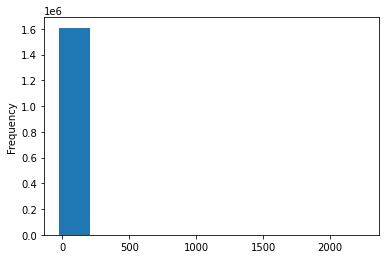

In [5]:
block_item_shop_sale = train.groupby(['date_block_num','item_id','shop_id'])['item_cnt_day'].sum()
block_item_shop_sale.plot.hist(bins=10)

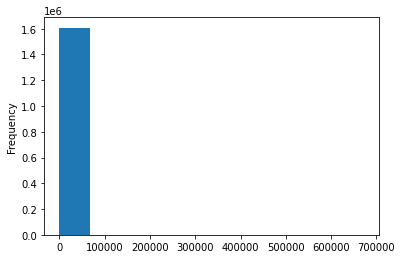

In [6]:
price_shop_sale = train.groupby(['date_block_num','item_id','shop_id'])['item_price'].sum()
price_shop_sale.plot.hist(bins=10)

It seems like there are some outliers near 2k for item_cnt_day. So, we should probably drop them to ease our life in the future.
Nearly the same picture is with prices, where at least one price is an outlier for sure.

## Data improvement

And here we are searching for this outliers from item_cnt_day and item_price.

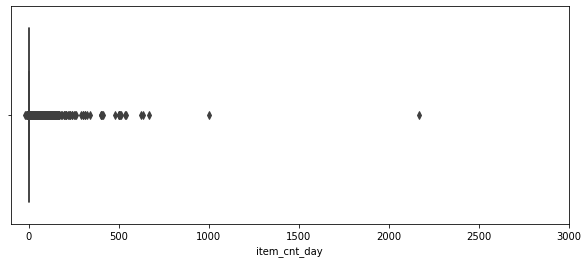

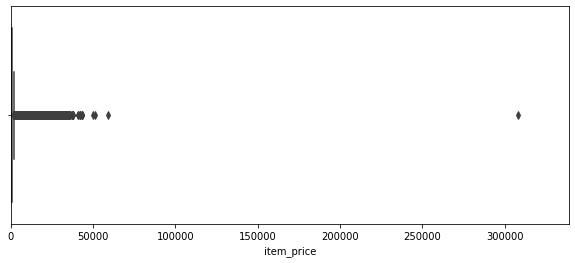

In [7]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

So, here they are. Two outliers for item_cnt_day and one for item_price. We need to drop them. Also, it looks like there is a negative price in one of the cases, which needs to be fixed.
After a short inspection it was found that this is a problem for shop "Серебряный Дом" (shop_id==32) and item "DmC Devil May Cry [PS3, русские субтитры]" (item_id=2973). Lets fit it with mean of price for this item for this very shop.

In [8]:
train = train[train.item_cnt_day<800]
train = train[train.item_price<100000]

mean = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.mean()
train.loc[train.item_price<0, 'item_price'] = mean

Several shops are duplicates of each other (according to its name). Fix train and test set.

In [9]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

#### Shop data improvement
There are also some majestic shop names, which have to be fixed to avoid some problems in the future. Also, here we split shop names into city, category and then encode them.

In [10]:
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops["shop_category"] = LabelEncoder().fit_transform(shops.category)
shops["shop_city"] = LabelEncoder().fit_transform(shops.city)
shops = shops[["shop_id", "shop_category", "shop_city"]]

#### Item categories improvement
Then we fix and encode data from item categories thanks to the data format.

In [11]:
categories["type_code"] = categories.item_category_name.apply( lambda x: x.split(" ")[0] ).astype(str)
categories.type_code = LabelEncoder().fit_transform(categories.type_code)
categories["split"] = categories.item_category_name.apply(lambda x: x.split("-"))
categories["subtype"] = categories.split.apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
categories["subtype_code"] = LabelEncoder().fit_transform(categories["subtype"])
categories = categories[["item_category_id", "subtype_code", "type_code"]]

#### Items improvement
Items data look good from the start, so, we should just drop ids.

In [12]:
items = items.drop('item_name', axis=1)

#### Prepairing grid for the feature generation
Most of the items in the test set target value should be zero, while train set contains only pairs which were sold or returned in the past. So we expand the train set to include those item-shop pairs with zero monthly sales. This way train data will be similar to test data.

In [13]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

grid = [] 
for block_num in train['date_block_num'].unique():
    cur_shops = train[train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = train[train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Transform the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

Aggregate train set by shop/item pairs to calculate target aggreagates, then <b>clip(0,20)</b> target value. This way train target will be similar to the test predictions.

Downcast item_cnt_month to float32 -- float16 was too small to perform sum operation.

In [14]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [15]:
gb = train.groupby(index_cols).agg({'item_cnt_day': ['sum']})
gb.columns = ['item_cnt_month']
gb.reset_index(inplace=True)
grid = pd.merge(grid, gb, on=index_cols, how='left')
grid['item_cnt_month'] = (grid['item_cnt_month'].fillna(0).clip(0,20).astype(np.float32))

#### Joining train and test sets
We use it to create all important features for both train and test sets.

In [16]:
test["date_block_num"] = 34
grid = pd.concat([grid, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=index_cols)

In [17]:
grid = pd.merge(grid, shops, on = ["shop_id"], how = "left")
grid = pd.merge(grid, items, on = ["item_id"], how = "left")
grid = pd.merge(grid, categories, on = ["item_category_id"], how = "left")

## Features generation

In [18]:
def lag_features(data, lags, col):
    tmp = data[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        print('Turn {} has started'.format(str(i)))
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        data = pd.merge(data, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        print('Turn {} has finished'.format(str(i)))
    return data

Usual lags for item through previous months.

In [19]:
grid = lag_features(grid, [1, 2, 3, 6, 9, 12], "item_cnt_month")

Turn 1 has started
Turn 1 has finished
Turn 2 has started
Turn 2 has finished
Turn 3 has started
Turn 3 has finished
Turn 6 has started
Turn 6 has finished
Turn 9 has started
Turn 9 has finished
Turn 12 has started
Turn 12 has finished


#### Adding data for lags
Here we create stats (mean/var) of sales of certain groups of features during the past 12 months

In [20]:
def group_stats(grid_, groupby_feats, target, enc_feat, last_periods):
    if not 'date_block_num' in groupby_feats:
        print ('date_block_num must in groupby_feats')
        return grid_
    
    gb = grid_.groupby(groupby_feats)[target].sum().reset_index()
    max_lags = np.max(last_periods)
    for i in range(1,max_lags+1):
        shifted = gb[groupby_feats+[target]].copy(deep=True)
        shifted['date_block_num'] += i
        shifted.rename({target:target+'_lag_'+str(i)},axis=1,inplace=True)
        gb = gb.merge(shifted, on=groupby_feats, how='left')
    gb.fillna(0,inplace=True)
    for period in last_periods:
        lag_feats = [target+'_lag_'+str(lag) for lag in np.arange(1,period+1)]
        mean = gb[lag_feats].sum(axis=1)/float(period)
        mean2 = (gb[lag_feats]**2).sum(axis=1)/float(period)
        gb[enc_feat+'_avg_sale_last_'+str(period)] = mean
        gb[enc_feat+'_std_sale_last_'+str(period)] = (mean2 - mean**2).apply(np.sqrt)
        gb[enc_feat+'_std_sale_last_'+str(period)].replace(np.inf,0,inplace=True)
        gb[enc_feat+'_avg_sale_last_'+str(period)] /= gb[enc_feat+'_avg_sale_last_'+str(period)].mean()
        gb[enc_feat+'_std_sale_last_'+str(period)] /= gb[enc_feat+'_std_sale_last_'+str(period)].mean()
    cols = groupby_feats + [f_ for f_ in gb.columns.values if f_.find('_sale_last_')>=0]
    grid = grid_.merge(gb[cols], on=groupby_feats, how='left')
    return grid

In [21]:
grid = group_stats(grid, ['date_block_num', 'item_id'], 'item_cnt_month', 'item', [12])
grid = group_stats(grid, ['date_block_num', 'shop_id'], 'item_cnt_month', 'shop', [12])
grid = group_stats(grid, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'category', [12])
grid = group_stats(grid, ['date_block_num', 'shop_city'], 'item_cnt_month', 'city', [12])
grid = group_stats(grid, ['date_block_num', 'type_code'], 'item_cnt_month', 'type', [12])
grid = group_stats(grid, ['date_block_num', 'subtype_code'], 'item_cnt_month', 'subtype', [12])

#### Lags generation
To begin with, we use target encoding for each group of features.

In [22]:
def target_encoding(grid_, groupby_feats, target, enc_feat, lags):
    print('target encoding for', groupby_feats)
    gb = grid_.groupby(groupby_feats).agg({target:'mean'})
    gb.columns = [enc_feat]
    gb.reset_index(inplace=True)
    grid = grid_.merge(gb, on=groupby_feats, how='left')
    grid[enc_feat] = grid[enc_feat].astype(np.float32)
    grid = lag_features(grid, lags, enc_feat)
    grid.drop(enc_feat, axis=1, inplace=True)
    return grid

Here we check existing columns, which may be used for lags generation.

In [23]:
for col in grid.columns: 
    print(col)

shop_id
item_id
date_block_num
item_cnt_month
shop_category
shop_city
item_category_id
subtype_code
type_code
item_cnt_month_lag_1
item_cnt_month_lag_2
item_cnt_month_lag_3
item_cnt_month_lag_6
item_cnt_month_lag_9
item_cnt_month_lag_12
item_avg_sale_last_12
item_std_sale_last_12
shop_avg_sale_last_12
shop_std_sale_last_12
category_avg_sale_last_12
category_std_sale_last_12
city_avg_sale_last_12
city_std_sale_last_12
type_avg_sale_last_12
type_std_sale_last_12
subtype_avg_sale_last_12
subtype_std_sale_last_12


And here I come to the massive feature generation, but there is a problem. I've got only 16GB of RAM, so not all of the features, which were planned, could've been generated.

In [24]:
grid = target_encoding(grid, ['date_block_num'], 'item_cnt_month', 'date_avg_item_cnt', [1])
grid = target_encoding(grid, ['date_block_num', 'item_id'], 'item_cnt_month', 'date_item_avg_item_cnt', [1,2,3,6,12])
grid = target_encoding(grid, ['date_block_num', 'shop_id'], 'item_cnt_month', 'date_shop_avg_item_cnt', [1,2,3,6,12])
grid = target_encoding(grid, ['date_block_num', 'item_category_id'], 'item_cnt_month', 'date_cat_avg_item_cnt', [1,2,3,6,12])
grid = target_encoding(grid, ['date_block_num', 'shop_category'], 'item_cnt_month', 'date_shop_cat_avg_item_cnt', [1,2,3,6,12])
grid = target_encoding(grid, ['date_block_num', 'type_code'], 'item_cnt_month', 'type_item_cnt', [1,2,3])
grid = target_encoding(grid, ['date_block_num', 'subtype_code'], 'item_cnt_month', 'subtype_item_cnt', [1])
grid = target_encoding(grid, ['date_block_num', 'shop_id', 'item_category_id'], 'item_cnt_month', 'date_shop_cat_avg_item_cnt', [1])
grid = target_encoding(grid, ['date_block_num', 'shop_city'], 'item_cnt_month', 'date_city_avg_item_cnt', [1])
# grid = target_encoding(grid, ['date_block_num', 'item_id', 'shop_city'], 'item_cnt_month', 'date_item_city_avg_item_cnt', [1])
grid = target_encoding(grid, ['date_block_num', 'item_id', 'type_code'], 'item_cnt_month', 'type_avg_item_cnt', [1])
# grid = target_encoding(grid, ['date_block_num', 'item_id', 'subtype_code'], 'item_cnt_month', 'subtype_avg_item_cnt', [1])

target encoding for ['date_block_num']
Turn 1 has started
Turn 1 has finished
target encoding for ['date_block_num', 'item_id']
Turn 1 has started
Turn 1 has finished
Turn 2 has started
Turn 2 has finished
Turn 3 has started
Turn 3 has finished
Turn 6 has started
Turn 6 has finished
Turn 12 has started
Turn 12 has finished
target encoding for ['date_block_num', 'shop_id']
Turn 1 has started
Turn 1 has finished
Turn 2 has started
Turn 2 has finished
Turn 3 has started
Turn 3 has finished
Turn 6 has started
Turn 6 has finished
Turn 12 has started
Turn 12 has finished
target encoding for ['date_block_num', 'item_category_id']
Turn 1 has started
Turn 1 has finished
Turn 2 has started
Turn 2 has finished
Turn 3 has started
Turn 3 has finished
Turn 6 has started
Turn 6 has finished
Turn 12 has started
Turn 12 has finished
target encoding for ['date_block_num', 'shop_category']
Turn 1 has started
Turn 1 has finished
Turn 2 has started
Turn 2 has finished
Turn 3 has started
Turn 3 has finished

#### Trend features

In [25]:
gb = train.groupby(['item_id']).agg({'item_price': ['mean']})
gb.columns = ['item_avg_item_price']
gb.reset_index(inplace=True)
grid = pd.merge(grid, gb, on=['item_id'], how='left')
gb = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
gb.columns = ['date_item_avg_item_price']
gb.reset_index(inplace=True)
grid = pd.merge(grid, gb, on=['date_block_num','item_id'], how='left')

Price trend for the last three months.

In [26]:
lags = [1,2]
grid = lag_features(grid, lags, 'date_item_avg_item_price')

for i in lags:
    grid['delta_price_lag_' + str(i)] = (grid['date_item_avg_item_price_lag_' + str(i)] - grid['item_avg_item_price']) / grid['item_avg_item_price']

Turn 1 has started
Turn 1 has finished
Turn 2 has started
Turn 2 has finished


In [27]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_' + str(i)]:
            return row['delta_price_lag_' + str(i)]
    return 0

In [28]:
grid['delta_price_lag'] = grid.apply(select_trend, axis=1)
grid['delta_price_lag'].fillna(0, inplace=True)

drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    drop += ['date_item_avg_item_price_lag_' + str(i)]
    drop += ['delta_price_lag_' + str(i)]

grid.drop(drop, axis=1, inplace=True)

Last month shop revenue trend.

In [29]:
gb = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
gb.columns = ['date_shop_revenue']
gb.reset_index(inplace=True)
grid = pd.merge(grid, gb, on=['date_block_num','shop_id'], how='left')
grid['date_shop_revenue'] = grid['date_shop_revenue'].astype(np.float32)

In [30]:
gb = gb.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
gb.columns = ['shop_avg_revenue']
gb.reset_index(inplace=True)
grid = pd.merge(grid, gb, on=['shop_id'], how='left')
grid['shop_avg_revenue'] = grid['shop_avg_revenue'].astype(np.float32)

In [32]:
grid['delta_revenue'] = (grid['date_shop_revenue'] - grid['shop_avg_revenue']) / grid['shop_avg_revenue']
grid['delta_revenue'] =grid['delta_revenue'].astype(np.float32)
grid = lag_features(grid, [1], 'delta_revenue')
grid.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

Turn 1 has started
Turn 1 has finished


## Add month and year

In [33]:
grid['month'] = grid['date_block_num'] % 12
grid['year'] = (grid['date_block_num'] / 12)

## Final preparations
Because of the using 12 as lag value drop first 12 months. Also drop all the columns with this month calculated values (other words which can not be calcucated for the test set).

In [ ]:
grid = grid[grid.date_block_num > 11]
grid.columns

In [ ]:
grid.to_csv('grid.csv')
del grid
del gb
del items
del shops
del categories
del train
gc.collect();

In [3]:
data = pd.read_csv('grid.csv')

In [4]:
data.dtypes

Unnamed: 0                   int64
shop_id                      int64
item_id                      int64
date_block_num               int64
item_cnt_month             float64
                            ...   
type_avg_item_cnt_lag_1    float64
delta_price_lag            float64
delta_revenue_lag_1        float64
month                        int64
year                       float64
Length: 61, dtype: object

In [5]:
data = data[[
    'shop_id', 'item_id', 'date_block_num', 'item_cnt_month',
       'shop_category', 'shop_city', 'item_category_id', 'subtype_code',
       'type_code', 'item_cnt_month_lag_1', 'item_cnt_month_lag_2',
       'item_cnt_month_lag_3', 'item_cnt_month_lag_6', 'item_cnt_month_lag_9',
       'item_cnt_month_lag_12', 'item_avg_sale_last_12',
       'item_std_sale_last_12', 'shop_avg_sale_last_12',
       'shop_std_sale_last_12', 'category_avg_sale_last_12',
       'category_std_sale_last_12', 'city_avg_sale_last_12',
       'city_std_sale_last_12', 'type_avg_sale_last_12',
       'type_std_sale_last_12', 'subtype_avg_sale_last_12',
       'subtype_std_sale_last_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_cat_avg_item_cnt_lag_2',
       'date_cat_avg_item_cnt_lag_3', 'date_cat_avg_item_cnt_lag_6',
       'date_cat_avg_item_cnt_lag_12', 'date_shop_cat_avg_item_cnt_lag_1_x',
       'date_shop_cat_avg_item_cnt_lag_2', 'date_shop_cat_avg_item_cnt_lag_3',
       'date_shop_cat_avg_item_cnt_lag_6', 'date_shop_cat_avg_item_cnt_lag_12',
       'type_item_cnt_lag_1', 'type_item_cnt_lag_2', 'type_item_cnt_lag_3', 
       'subtype_item_cnt_lag_1',
       'date_shop_cat_avg_item_cnt_lag_1_y', 'date_city_avg_item_cnt_lag_1',
       'type_avg_item_cnt_lag_1', 'delta_price_lag', 'delta_revenue_lag_1',
       'month', 'year'
]]

cat_feats = ['shop_id', 'shop_category', 'shop_city', 'item_category_id', 'type_code', 'subtype_code']

## Modelling and training

Here we are just splitting our data into train, valuation and test. Valuation takes only 33rd month because we have to make it with the same logic as in the test set, which is only one month size.

In [6]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_val = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_val = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

del data
gc.collect();

#### Models initialization

Timer for models.

In [7]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time.time()
    yield
    d = time.time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

Wrapper for LightGBM / XGBoost / CATBoost

In [24]:
class TreeModel:
    def __init__(self, model_type: str):
        self.model_type = model_type
        self.trn_data = None
        self.val_data = None
        self.model = None

    def train(self,
              params: dict,
              X_train: pd.DataFrame, y_train: np.ndarray,
              X_val: pd.DataFrame, y_val: np.ndarray,
              train_weight: tp.Optional[np.ndarray] = None,
              val_weight: tp.Optional[np.ndarray] = None,
              train_params: dict = {}):
        if self.model_type == "lgb":
            self.trn_data = lgb.Dataset(X_train, label=y_train, weight=train_weight)
            self.val_data = lgb.Dataset(X_val, label=y_val, weight=val_weight)
            self.model = lgb.train(params=params,
                                   train_set=self.trn_data,
                                   valid_sets=[self.trn_data, self.val_data],
                                   **train_params)
            self.save = self.model.save_model('lgb.txt')
        elif self.model_type == "xgb":
            self.trn_data = xgb.DMatrix(X_train, y_train, weight=train_weight)
            self.val_data = xgb.DMatrix(X_val, y_val, weight=val_weight)
            self.model = xgb.train(params=params,
                                   dtrain=self.trn_data,
                                   evals=[(self.trn_data, "train"), (self.val_data, "val")],
                                   **train_params)
            self.save = self.model.save_model('xgb.json')
        elif self.model_type == "cat":
            self.trn_data = Pool(X_train, label=y_train, group_id=[0] * len(X_train))
            self.val_data =  Pool(X_val, label=y_val, group_id=[0] * len(X_val))
            self.model = CatBoost(params)
            self.model.fit(
                self.trn_data, eval_set=[self.val_data], use_best_model=True, **train_params)
            self.save = self.model.save_model('cat.json', format='json')
        else:
            raise NotImplementedError

    def predict(self, X: pd.DataFrame):
        if self.model_type == "lgb":
            return self.model.predict(
                X, num_iteration=self.model.best_iteration)  # type: ignore
        elif self.model_type == "xgb":
            X_DM = xgb.DMatrix(X)
            return self.model.predict(
                X_DM, ntree_limit=self.model.best_ntree_limit)  # type: ignore
        elif self.model_type == "cat":
            return self.model.predict(X)
        else:
            raise NotImplementedError

    @property
    def feature_names_(self):
        if self.model_type == "lgb":
            return self.model.feature_name()
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").keys())
        elif self.model_type == "cat":
             return self.model.feature_names_
        else:
            raise NotImplementedError

    @property
    def feature_importances_(self):
        if self.model_type == "lgb":
            return self.model.feature_importance(importance_type="gain")
        elif self.model_type == "xgb":
            return list(self.model.get_score(importance_type="gain").values())
        elif self.model_type == "cat":
            return self.model.feature_importances_
        else:
            raise NotImplementedError

Universal function for calling LightGBM, XGBoost or Catboost. It was changed a little bit from the original look due to the time series we are predicting for this champ.

In [22]:
def run_train_and_inference(X_train, X_val, X_test, Y_train, Y_val, use_model, model_params, train_params, seed_list, n_splits):
    
    import xgboost as xgb
    import lightgbm as lgb
    import catboost as cat
    
    oof_pred_arr = np.zeros(len(X_val))
    test_pred_arr = np.zeros(len(X_test))
    feature_importances = pd.DataFrame()
    score_list = []
    Y_test = np.zeros(len(X_test))
    
    for seed in seed_list:
        fold = 1
        if use_model == "cat":
            model_params['random_state'] = seed
        else:
            model_params["seed"] = seed
        tmp_oof_pred = np.zeros(len(X_val))
        tmp_test_pred = np.zeros(len(X_test))
        print("*" * 100)
        print(f"Seed: {seed}")

        model = TreeModel(model_type=use_model)
        with timer(prefix="Model training "):
            model.train(
                params=model_params, X_train=X_train, y_train=Y_train,
                X_val=X_val, y_val=Y_val, train_params=train_params)
        fi_tmp = pd.DataFrame()
        fi_tmp["feature"] = model.feature_names_
        fi_tmp["importance"] = model.feature_importances_
        fi_tmp["fold"] = fold
        fi_tmp["seed"] = seed
        feature_importances = feature_importances.append(fi_tmp)

        val_pred = model.predict(X_val)
        score = mean_squared_error(Y_val, val_pred, squared=False)
        print(f"score: {score:.5f}")
        score_list.append([seed, fold, score])
        tmp_oof_pred = val_pred
        tmp_test_pred += model.predict(X_test)
            
        oof_score = mean_squared_error(Y_val, tmp_oof_pred, squared=False)
        print(f"oof score: {oof_score: 5f}")
        score_list.append([seed, "oof", oof_score])

        oof_pred_arr += tmp_oof_pred
        test_pred_arr += tmp_test_pred / n_splits

    oof_pred_arr /= len(seed_list)
    test_pred_arr /= len(seed_list)
    
    oof_score = mean_squared_error(Y_val, oof_pred_arr, squared=False)
    score_list.append(["avg", oof_score])
    score_df = pd.DataFrame(
        score_list, columns=["seed", "fold", "rmse score"])
    
    return oof_pred_arr, test_pred_arr, score_df, feature_importances

In [10]:
N_SPLITS = 1
RANDOM_SEED_LIST = [
    1003,
    # 2021, 0, 1086, 39
]

MODEL_PARAMS = {
    "lgb": {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'feature_pre_filter': False,
        'lambda_l1': 0.0,
        'lambda_l2': 0.0,
        'num_leaves': 102,
        'feature_fraction': 0.4,
        'bagging_fraction': 1.0,
        'bagging_freq': 0,
        'min_child_samples': 20,
        'learning_rate': 0.05,
        'max_depth': 8
    },
    "xgb": {
        "objective": "reg:squarederror",
        "learning_rate": 0.1,
        "seed": RANDOM_SEED_LIST[0],
        "max_depth": 10,
        "subsample": .8,
        "colsample_bytree": .8,
        "n_jobs": 2,
        "tree_method": "auto",
        "min_child_weight": 0.5
    },
    "cat": {
        'loss_function': 'RMSE',
        'learning_rate': 0.1,
        'max_depth': 7,
        'random_state': RANDOM_SEED_LIST[0],
        "thread_count": 2,
        'num_boost_round': 1000,
    }
}
TRAIN_PARAMS = {
    "lgb": {
        'categorical_feature': cat_feats,
        "num_boost_round": 1000,
        "early_stopping_rounds": 200,
        "verbose_eval": 100,
    },
    "xgb": {
        "num_boost_round": 1000,
        "early_stopping_rounds": 200,
        "verbose_eval":  100,
    },
    "cat": {
        'early_stopping_rounds': 200, 
        'verbose_eval': 100,
    }
}

#### Light GBM
Making a prediction for LightGBM model.

In [39]:
# Uncomment row under to load model. Than you can try anything you want with it.
# lgbmod = lgb.Booster(model_file='lgb.txt')

In [25]:
oof_pred_lgb, test_pred_lgb, score_lgb, feat_imps_lgb = run_train_and_inference(
    X_train, X_val, X_test, Y_train, Y_val,  "lgb", MODEL_PARAMS["lgb"], TRAIN_PARAMS["lgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 1003
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.793336	valid_1's rmse: 0.898669
[200]	training's rmse: 0.768866	valid_1's rmse: 0.900688
Early stopping, best iteration is:
[73]	training's rmse: 0.804516	valid_1's rmse: 0.89756
Model training 56.131[s]
score: 0.89756
oof score:  0.897560


In [26]:
score_lgb

,seed,fold,rmse score
0,1003,1,0.89756
1,1003,oof,0.89756
2,avg,0.89756,NaN


In [27]:
score_lgb.loc[score_lgb.fold == "oof"]

,seed,fold,rmse score
1,1003,oof,0.89756


Here we are building histogram for the importance level of the features.

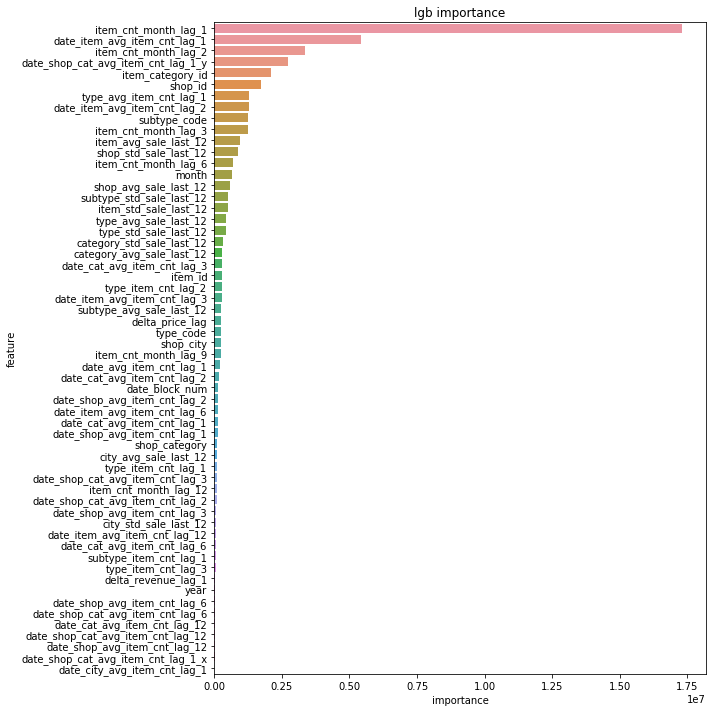

In [28]:
order = list(feat_imps_lgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_lgb, order=order)
plt.title("{} importance".format("lgb"))
plt.tight_layout()

#### XGBoost
Making a prediction for XGBoost model.

In [46]:
# Uncomment rows under to load model. Than you can try anything you want with it.
# xgbmod = xgb.XGBRegressor()
# booster = xgb.Booster()
# booster.load_model('xgb.json')
# xgbmod._Booster = booster

In [29]:
oof_pred_xgb, test_pred_xgb, score_xgb, feat_imps_xgb = run_train_and_inference(
    X_train, X_val, X_test, Y_train, Y_val,  "xgb", MODEL_PARAMS["xgb"], TRAIN_PARAMS["xgb"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 1003
[0]	train-rmse:1.15883	val-rmse:1.11946
[100]	train-rmse:0.70205	val-rmse:0.91422
[200]	train-rmse:0.66003	val-rmse:0.92553
[223]	train-rmse:0.65336	val-rmse:0.92664
Model training 5017.560[s]
score: 0.90093
oof score:  0.900933


In [33]:
score_xgb

,seed,fold,rmse score
0,1003,1,0.900933
1,1003,oof,0.900933
2,avg,0.900933,NaN


In [34]:
score_xgb.loc[score_xgb.fold == "oof"]

,seed,fold,rmse score
1,1003,oof,0.900933


Here we are building histogram for the importance level of the features.

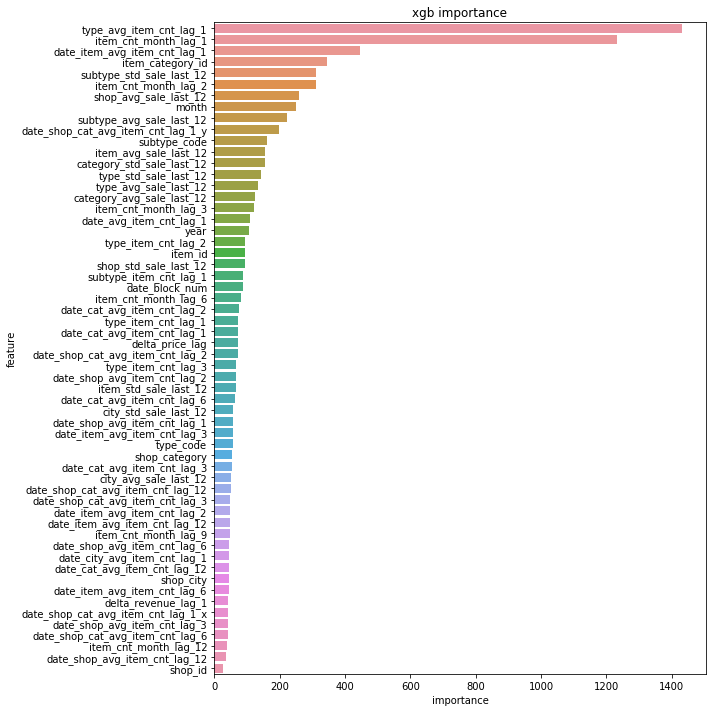

In [32]:
order = list(feat_imps_xgb.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_xgb, order=order)
plt.title("{} importance".format("xgb"))
plt.tight_layout()

#### CatBoost
Making a prediction for CatBoost model.

In [54]:
# Uncomment rows under to load model. Than you can try anything you want with it.
# catmod = CatBoostRegressor()
# catmod.load_model('cat.json', format='json')

In [35]:
oof_pred_cat, test_pred_cat, score_cat, feat_imps_cat = run_train_and_inference(
    X_train, X_val, X_test, Y_train, Y_val,  "cat", MODEL_PARAMS["cat"], TRAIN_PARAMS["cat"], RANDOM_SEED_LIST, N_SPLITS)

****************************************************************************************************
Seed: 1003
0:	learn: 1.1452250	test: 1.1068994	best: 1.1068994 (0)	total: 1.36s	remaining: 22m 42s
100:	learn: 0.8296146	test: 0.9121683	best: 0.9121683 (100)	total: 1m 56s	remaining: 17m 12s
200:	learn: 0.8066814	test: 0.9011367	best: 0.9008004 (192)	total: 3m 47s	remaining: 15m 4s
300:	learn: 0.7926609	test: 0.9009928	best: 0.9001405 (214)	total: 5m 42s	remaining: 13m 15s
400:	learn: 0.7812071	test: 0.9053477	best: 0.8999610 (325)	total: 7m 36s	remaining: 11m 22s
500:	learn: 0.7726129	test: 0.9037978	best: 0.8999610 (325)	total: 9m 29s	remaining: 9m 27s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.8999610133
bestIteration = 325

Shrink model to first 326 iterations.
Model training 610.238[s]
score: 0.89996
oof score:  0.899961


In [37]:
score_cat

,seed,fold,rmse score
0,1003,1,0.899961
1,1003,oof,0.899961
2,avg,0.899961,NaN


In [36]:
score_cat.loc[score_cat.fold == "oof"]

,seed,fold,rmse score
1,1003,oof,0.899961


Here we are building histogram for the importance level of the features.

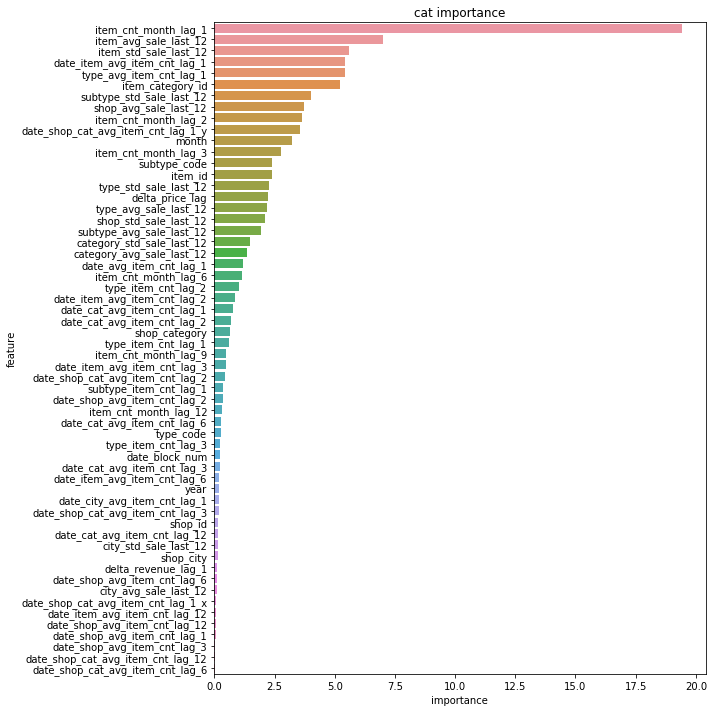

In [38]:
order = list(feat_imps_cat.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feat_imps_cat, order=order)
plt.title("{} importance".format("cat"))
plt.tight_layout()

#### Ensemble LightGBM, XGBoost, Catboost

Ensembling three models with different weights due to their validation performance.

In [ ]:
oof_pred_avg = oof_pred_lgb*0.45 + oof_pred_xgb*0.2 + oof_pred_cat*0.35
oof_score_avg = mean_squared_error(Y_val, oof_pred_avg, squared=False)

print(f"oof score avg: {oof_score_avg:.5f}")

oof score avg: 0.89240


Making final prediction.

In [ ]:
test_pred_avg = test_pred_lgb*0.45 + test_pred_xgb*0.2 + test_pred_cat*0.35

In [ ]:
sub = pd.DataFrame({"ID": test.index, "item_cnt_month": test_pred_avg})

In [ ]:
sub.to_csv('pds_ens.csv', index=None)